<a href="https://colab.research.google.com/github/tdushio/shiolabOpen/blob/master/32_Demo_LQR%E3%81%AB%E3%82%88%E3%82%8B%E5%80%92%E7%AB%8B%E6%8C%AF%E5%AD%90%E3%81%AE%E5%AE%89%E5%AE%9A%E5%8C%96%E5%88%B6%E5%BE%A1_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 32.Demo_LQRによる倒立振子の安定化制御

※これは Qiitaで紹介された記事
「Python使って、LMIを解いて、倒立振り子の状態フィードバック制御器を設計する」
：https://qiita.com/R-second/items/78fb38dece73db13b834　をもとに汐月がLQRによる制御系設計用にアレンジしたスクリプトです。



## LQR最適化問題

LQRはLinear Quadratic Regulator の略です。<br>
Linear は制御対象が線形システムであることを意味します。<br>
Quadratic は評価関数が２次形式であることを意味します。<br>
Regulator は制御目的がシステムの安定化であることを意味します<br>
すなわち、線形システムの入出力信号という制約のもとで、信号から定義される評価関数を最小化する信号間の関係を求めます。<br>
解の存在はシステムが安定化されることを意味します。


## 制御対象のモデル
倒立振子のモデルを
$1$ 入力$4$出力$4$次の線形時不変システム(LTI)で与える。<br>
\begin{equation}
   \dot{x}(t) = A x(t) + B u(t) , \;
    y(t) = C x(t),\;\; x(0)=x_0  \nonumber
\end{equation}
ここで、状態$x(t)\in{\mathrm R}^4$は
$x=[z,\theta,\dot{z},\dot{\theta}]^\top$、
$u(t)\in{\mathrm R}$はモータへの入力である。
$x_0\in{\mathrm R}^4$は初期状態を表す。

(詳しいパラメータの意味や値は本質的ではないので、ここでは割愛)

## 制御の目的

この制御対象に対し、以下の評価関数を定義する。<br>
\begin{equation}
  J = \int_0^\infty
  \left( x^\top(t)Qx(t) + u^\top(t)Ru(t)
  \right)  \mathrm{d}t
\end{equation}
ただし、$Q,R$は設計パラメータとして与える正定対称行列である。<br>
制御の目的はこの評価関数 $J$ を最小化する $u$ を求めることである。
解が存在する、すなわち$J<\infty$となる$u$が存在するれば
$x(\infty)=0, u(\infty)=0$なので、安定化条件は満たされる。


## ＜解説＞
制御目的は、時間応答波形の特徴で定量的に定義されている。<br>
制御手法は、状態フィードバックを選択している<br>
制御器設計手法は、LMIを採用している<br>
LMIとは、線形行列不等式(Linear Matrix Inequality)を拘束条件とする最適化問題の解法

# LQR

LQR問題の解は状態フィードバック則
\begin{equation}
   u(t) = -K x(t)
\end{equation}
で得られる。<br>
この状態フィードバックゲイン$K\in{\mathrm R}^{1\times 4}$
はリッカチ方程式
\begin{equation}
   A^\top P + PA +Q -PBR^{-1}B^\top P = 0
\end{equation}
の正定対称解 $P^*$を用いて
\begin{equation}
   K = R^{-1}B^\top B
\end{equation}
で得られる。

# モジュールのインストール
以下のライブラリを使用する。


*   numpy
*   matplotlib
*   control (制御工学ライブラリ)
*   cvxpy (LMIを求解するためのライブラリ)

### <参考>
<A href="https://python-control.readthedocs.io/en/0.10.0/">制御工学モジュール control のドキュメント</a><br>
<A href="https://numpy.org/doc">numpy のドキュメント</A><br>
<A href="https://matplotlib.org/stable/index.html">matplotlib のドキュメント</A><br>
<A href="https://www.cvxpy.org/">cvxpy のドキュメント</A>

In [ ]:
import numpy as np
import cvxpy as cp
# !pip install slycot
!pip install control
from control import matlab   # matlab 互換関数を使用する場合
import matplotlib.pyplot as plt

# プログラム

1.  状態方程式の作成
2.  LMI条件の作成
3.  求解
4. 制御器の復元
5. シミュレーション




# 制御対象のモデル
倒立振子のモデルを
$1$ 入力$4$出力$4$次の線形時不変システム(LTI)で与える。<br>
\begin{equation}
   \dot{x}(t) = A x(t) + B u(t) , \;
    y(t) = C x(t),\;\; x(0)=x_0  \nonumber
\end{equation}
ここで、$u(t)\in{\mathrm R}$はモータへの入力,
$y(t)\in{\mathrm R}^4$は出力,$x(t)\in{\mathrm R}^4$は状態の時刻$t\in [0,T_f]$での値を成分とする列ベクトルである。<br>
$\dot{x}$は状態$x$の導関数を表す。<br>
$A\in{\mathrm R}^{4\times 4}$,$B\in{\mathrm R}^{4\times 1}$,$C\in{\mathrm R}^{4\times 4}$,$D\in{\mathrm R}^{4\times 1}$は定数行列である.<br>
$x_0\in{\mathrm R}^4$は初期状態を表す。

制御対象に関わる物理量

In [ ]:
l = 0.15             # 振子の長さ
m = 0.0402           # 振子の質量
Jp = 0.00030142      # 振子の慣性モーメント
M = 0.6862           # 台車の質量
Jt = 1.34 * 10**(-4)
Jm = 1.30 * 10**(-7)
Jc = Jt + Jm
r = 0.02485
F = 0.36
c = 0.0015
g = 9.80665
a = 1.9

p = M + m + Jc/(r*r)
q = Jp + m*l*l
W = 1/(p * q - m * m * l * l)


係数行列の作成

In [ ]:
A = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, -m*m*g*l*l*W, -F*q*W, c*m*l*W],
    [0, m*g*l*p*W, F*m*l*W, -c*p*W]
    ])
B = np.array([[0, 0, a*q*W, -a*m*l*W]]).T
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
D = np.zeros((2, 1))

# 今回は使わないが、状態空間の生成は以下
sys = matlab.ss(A, B, C, D)


In [ ]:
Q = np.diag(np.array([1,1,1,1]))
R = np.array([1])
print(Q)
print(R)
K,P,E = matlab.lqr(sys,Q,R)
matlab.care(A,B,Q,R)

[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
[1]


# シミュレーション
## 閉ループ系の構成
状態フィードバックをかけたときの閉ループ系は以下で与えられる.
\begin{equation}
   \dot{x}(t) = (A+BK) x(t), \;\;
    y(t) = C x(t),\;\; x(0)=x_0  \nonumber
\end{equation}
これを構成する.

In [ ]:
A_ = A - B @ K
B_ = np.zeros((4, 1))
C_ = C
D_ = D

sys_cl = matlab.ss(A_, B_, C_, D_)       # 状態空間モデル

## 時間応答の観察
matlab.initialで、システムのゼロ入力応答を取得する.

In [ ]:
# 初期値応答
Td = np.arange(0, 10, 0.01)    #シミュレーション時間
rng = np.random.default_rng()
print(rng)
x0 = rng.random((4,1))                    #初期値
z, t, x = matlab.initial(sys_cl, Td, x0 ,return_x=True)
u = (-K @ x.T).T

Generator(PCG64)


応答波形を描画する

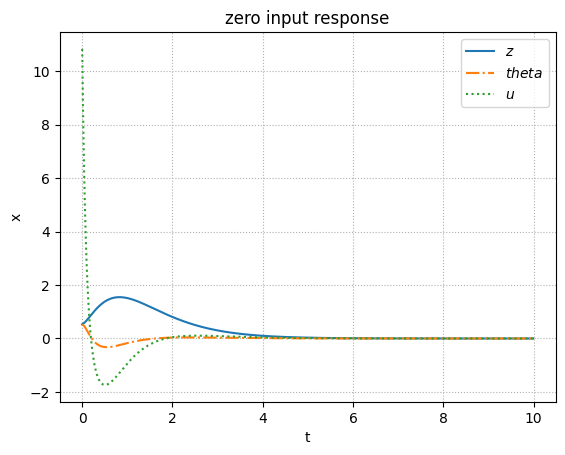

In [ ]:
# 初期値応答の描画
fig, ax = plt.subplots()
ax.plot(t, x[:, 0], label = '$z$')
ax.plot(t, x[:, 1], ls = '-.', label = '$theta$')
ax.plot(t, u , ls = ':', label = '$u$')
ax.set_title('zero input response')

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.grid(ls=':')
ax.legend(loc='best')
plt.show()

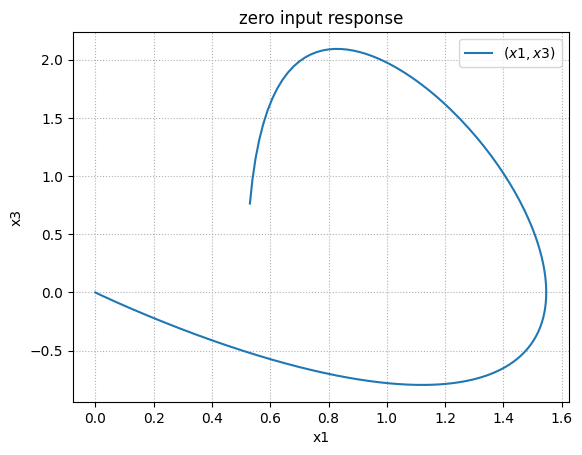

In [ ]:
fig, ax = plt.subplots()
ax.plot(x[:, 0], x[:,2], label = '$(x1,x3)$')
ax.set_title('zero input response')

ax.set_xlabel('x1')
ax.set_ylabel('x3')
ax.grid(ls=':')
ax.legend(loc='best')
plt.show()